# 感情分析

## タスク設定

宿に関するレビューに関して、次を行うモデルを開発します。

* レビューの中からなるべく多くのネガティブな意見を把握する
* 何件レビューが来るかわからないため、現時点で全件チェックできるかわからない。従って、信頼度が大きいものから順になるべく効率的にネガティブな意見を把握する

## 評価方法

タスク設定を考えると、Recallを主にした評価が適切そうです。

信頼度が大きいものから順になるべく効率的にネガティブな意見を把握したいということなので、
学習時にはPrecision-Recallカーブの下の面積であるAverage Precisionを最大化するように学習し、
最終的なレポート時には
「recall 80%のもとでprecisionが~%」のような表現にする方針がよさそうです。

## データ作成

ここでは、JRTEコーパスを利用します。

## アノテーション結果の検証

アノテーション結果の検証については
[アノテーション結果の検証](annotation.ipynb)
に詳しく書いていますので、そちらを確認してください。

今回は最終的にジャッジが一致しているデータを利用することにします。

In [1]:
import pandas as pd

data = pd.read_csv("input/pn_same_judge.csv")

## データの概要把握

In [2]:
data.head()

,label,text,judges
0,neutral,出張でお世話になりました。,"{""0"": 3}"
1,neutral,朝食は普通でした。,"{""0"": 3}"
2,positive,また是非行きたいです。,"{""1"": 3}"
3,positive,また利用したいと思えるホテルでした。,"{""1"": 3}"
4,neutral,新婚旅行で利用しました。,"{""0"": 3}"


In [3]:
data.shape

(4186, 3)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4186 entries, 0 to 4185
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4186 non-null   object
 1   text    4186 non-null   object
 2   judges  4186 non-null   object
dtypes: object(3)
memory usage: 98.2+ KB


In [5]:
# 欠損値がないことを確認
data.isnull().sum()

label     0
text      0
judges    0
dtype: int64

In [6]:
# ユニークな値を確認
data.describe(include=[object]).T

,count,unique,top,freq
label,4186,3,positive,2835
text,4186,4186,出張でお世話になりました。,1
judges,4186,3,"{""1"": 3}",2835


In [7]:
data.describe().T

,count,unique,top,freq
label,4186,3,positive,2835
text,4186,4186,出張でお世話になりました。,1
judges,4186,3,"{""1"": 3}",2835


In [8]:
data["label"].value_counts()

positive    2835
neutral      749
negative     602
Name: label, dtype: int64

最後に学習用に数字のラベルも付与しておきましょう。
ネガティブな意見を抽出したいので、negativeラベルに1を、その他のラベルpositive, neutralには0を付与しておきます。

In [9]:
data["label_num"] = data["label"].map({"positive": 0, "neutral": 0, "negative": 1})

In [59]:
data.groupby("label_num").describe()

label                         text                               \
          count unique       top  freq count unique              top freq   
label_num                                                                   
0          3584      2  positive  2835  3584   3584    出張でお世話になりました。    1   
1           602      1  negative   602   602    602  期待していただけに残念でした。    1   

          judges                          
           count unique        top  freq  
label_num                                 
0           3584      2   {"1": 3}  2835  
1            602      1  {"-1": 3}   602

## データの分割

テストデータの内容は確認したいことが重要なので、探索的データ分析をする前に分割しておきましょう。

positiveとneutralは共に負例として扱いますが、分布自体は保っておきたいため `stratify` 引数には
`data["label_num"]` では **なく** `data["label"]` を指定していることに注意してください。

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.1, random_state=0, stratify=data["label"])

In [13]:
train.shape, test.shape

((3767, 4), (419, 4))

## ベースラインモデルの構築

まずは簡単なモデルを作成し、どの程度の精度ができるのかを確かめてみましょう。

ここでは、次のモデルを学習してCVで結果を比較します。

* Naive Bayes
* Logistic Regression
* SVM
* Random Forest

ベクトル化にはTfidfVectorizerを利用することにします。

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

結果のPRカーブを書くためには各フォールドのprediction結果を保持しておく必要があります。
そこで、GridSearchCVではなくParameterGridを使ってカスタムでループを回します。

In [19]:
from sklearn.model_selection import ParameterGrid
import numpy as np


def run_cv(pipe, params, cv, X, y, stratify):
    result = []
    for param in ParameterGrid(params):
        pipe.set_params(**param)
        print(pipe)
        pred = np.zeros((len(X), ))
        for fold_id, (train_idx, test_idx) in enumerate(cv.split(X=X, y=stratify)):
            print("Fold:", fold_id)
            
            # neutralもstratifyするためにここでmapを行う
            pipe.fit(X=X.iloc[train_idx], y=y.iloc[train_idx])
            try:
                pred[test_idx] = pipe.predict_proba(X.iloc[test_idx])[:,1]
            except AttributeError:
                # For SVM
                pred[test_idx] = pipe.decision_function(X.iloc[test_idx])

        result.append((param, pred))
    return result

トークナイザを定義します。

In [20]:
import spacy

nlp = spacy.load("ja_core_news_sm")


def tokenize(text, stopwords=set()):
    return [t.lemma_ for t in nlp(text) if t.lemma_ not in stopwords]

2022-05-09 05:54:09.828683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 05:54:09.828770: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


クロスバリデーションの設定をします。

今回はデータが少ないので、フォールドごとにテストデータが少なくなってしまうのをさけるために
フォールド数は小さめに 3 に設定することにします。

In [23]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [24]:
pipe = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", MultinomialNB())
])

params = [
    {
        "clf": [
            MultinomialNB(),
            LogisticRegression(random_state=0),
            SVC(random_state=0),
            RandomForestClassifier(random_state=0)
        ],
    },
]

# ここでも neutral と positive の分布を保つために
# stratify には train["label_num"] ではなく train["label"]を渡していることに注意
result = run_cv(pipe=pipe, params=params, cv=cv, X=train["text"], y=train["label_num"], stratify=train["label"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f228bc9de50>)),
                ('clf', MultinomialNB())])
Fold: 0
Fold: 1
Fold: 2
Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f228bc9de50>)),
                ('clf', LogisticRegression(random_state=0))])
Fold: 0
Fold: 1
Fold: 2
Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f228bc9de50>)),
                ('clf', SVC(random_state=0))])
Fold: 0
Fold: 1
Fold: 2
Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f228bc9de50>)),
                ('clf', RandomForestClassifier(random_state=0))])
Fold: 0
Fold: 1
Fold: 2


結果を描画します。

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay

def show_pr(result, y):
    """run_cvの結果からPRカーブを描画する関数"""
    _, ax = plt.subplots(figsize=(10, 5))
    for model_id, (param, pred) in enumerate(result):
        print(model_id, param)
        PrecisionRecallDisplay.from_predictions(ax=ax, y_true=y, y_pred=pred, name=f"Model-{model_id}")

0 {'clf': MultinomialNB()}
1 {'clf': LogisticRegression(random_state=0)}
2 {'clf': SVC(random_state=0)}
3 {'clf': RandomForestClassifier(random_state=0)}


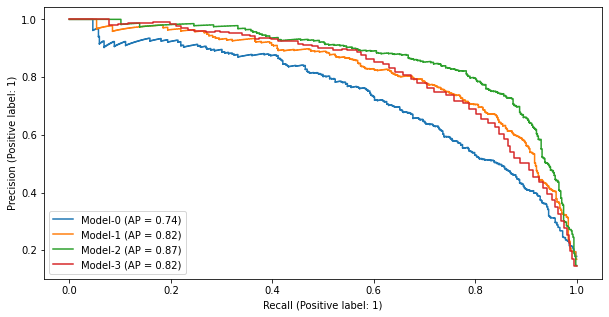

In [26]:
show_pr(result=result, y=train["label_num"])

SVCの結果が良好ですので、ここではベースラインとしてSVCを使うことにします。

## モデルの改良

### 探索的データ分析

探索的データ分析では、データを観察し分類に寄与しそうな仮説を探します。

ここでは、
BoWの次元は大きくなりやすく次元の呪いの問題を受けやすい問題に対して、
ストップワードを取り入れて分類に寄与しそうにない単語は取り除いて
精度が向上するかをみてみることにします。

まずはラベル毎に単語を頻度が大きい順にいくつか出力してみます。

In [32]:
from collections import Counter


def count_words(sr, tokenize):
    cnt = Counter()
    for words in sr.apply(lambda sent: tokenize(sent)):
        cnt.update(words)
    return cnt


"""
def show_most_frequent_words(df, tokenize, stopwords=set(), top_n=50):
    for label in df["label"].unique():
        print(f"label: {label}, top-{top_n} most frequent word")
        pos_words = count_words(df.query('label == @label'), tokenize=tokenize)
        print(pd.Series(pos_words).sort_values(ascending=False).iloc[:top_n])
"""

'\ndef show_most_frequent_words(df, tokenize, stopwords=set(), top_n=50):\n    for label in df["label"].unique():\n        print(f"label: {label}, top-{top_n} most frequent word")\n        pos_words = count_words(df.query(\'label == @label\'), tokenize=tokenize)\n        print(pd.Series(pos_words).sort_values(ascending=False).iloc[:top_n])\n'

In [37]:
cnt_1 = count_words(train.query('label_num == 1')["text"], tokenize=tokenize)
cnt_1.most_common(n=50)

[('。', 488),
 ('が', 443),
 ('の', 437),
 ('た', 408),
 ('、', 277),
 ('です', 244),
 ('に', 226),
 ('は', 204),
 ('て', 201),
 ('ます', 196),
 ('だ', 182),
 ('と', 161),
 ('する', 145),
 ('ない', 107),
 ('も', 98),
 ('残念', 91),
 ('を', 82),
 ('か', 79),
 ('部屋', 76),
 ('で', 73),
 ('ある', 72),
 ('いる', 59),
 ('ぬ', 58),
 ('お', 56),
 ('風呂', 53),
 ('.', 47),
 ('ただ', 40),
 ('思う', 39),
 ('なる', 39),
 ('少し', 38),
 ('狭い', 33),
 ('れる', 30),
 ('朝食', 30),
 ('？', 29),
 ('から', 27),
 ('・', 26),
 ('てる', 25),
 ('時', 25),
 ('悪い', 25),
 ('ちょっと', 24),
 ('気', 24),
 ('方', 20),
 ('こと', 19),
 ('な', 19),
 ('フロント', 18),
 ('人', 17),
 ('良い', 17),
 ('掃除', 17),
 ('入る', 17),
 ('（', 16)]

In [38]:
cnt_0 = count_words(train.query('label_num == 0')["text"], tokenize=tokenize)
cnt_0.most_common(n=50)

[('。', 2928),
 ('た', 2324),
 ('です', 1605),
 ('ます', 1299),
 ('の', 1261),
 ('も', 1108),
 ('て', 813),
 ('が', 798),
 ('だ', 757),
 ('する', 722),
 ('は', 716),
 ('に', 705),
 ('、', 701),
 ('で', 475),
 ('と', 447),
 ('良い', 417),
 ('お', 384),
 ('を', 334),
 ('部屋', 297),
 ('利用', 290),
 ('ある', 268),
 ('とても', 228),
 ('美味しい', 202),
 ('ホテル', 193),
 ('また', 191),
 ('満足', 183),
 ('いる', 182),
 ('思う', 179),
 ('!', 178),
 ('風呂', 173),
 ('たい', 169),
 ('朝食', 167),
 ('から', 141),
 ('できる', 126),
 ('最高', 123),
 ('対応', 108),
 ('広い', 108),
 ('大', 105),
 ('なる', 104),
 ('こと', 102),
 ('行く', 101),
 ('ない', 101),
 ('綺麗', 96),
 ('よい', 96),
 ('いただく', 91),
 ('せる', 89),
 ('温泉', 88),
 ('方', 80),
 ('清潔', 79),
 ('か', 78)]

この結果をみながらストップワードを定義してみましょう。

```{note}
問題によってストップワードが何かという基準は変わってきます。
やみくもに公開されているストップワード辞書を使うのではなく、データを見てストップワードを決めましょう。
```

一方のラベルにのみ頻繁に出現しているような、各ラベルで特徴的な単語は残し、それ以外は除去を行います。
ここでは次のようにストップワードを定義してみます。

In [53]:
stopwords = {
    "。", "、", "！", "!", "？", "(", ")", "（", "）",
    "です", "ます", "する", "なる", "ある", "いる",
    "れる", "いう", "から", "てる", "せる",
    "が", "の", "た", "は", "に", "だ", "て", "と", "も", "を", "お", "で", "か",
    "こと", "方", "的", 
    "な", "ば", "ね", "や", "ず", "つ",  "ぬ",
    "よう", "ござる",
    ".", "・",
}

In [54]:
count_words(
    train.query('label_num == 1')["text"],
    tokenize= lambda x: tokenize(x, stopwords=stopwords)
).most_common(n=50)

[('ない', 107),
 ('残念', 91),
 ('部屋', 76),
 ('風呂', 53),
 ('ただ', 40),
 ('思う', 39),
 ('少し', 38),
 ('狭い', 33),
 ('朝食', 30),
 ('時', 25),
 ('悪い', 25),
 ('ちょっと', 24),
 ('気', 24),
 ('フロント', 18),
 ('人', 17),
 ('良い', 17),
 ('掃除', 17),
 ('入る', 17),
 ('しまう', 16),
 ('時間', 15),
 ('もう', 15),
 ('だけ', 15),
 ('とても', 15),
 ('駐車', 14),
 ('事', 14),
 ('露天', 14),
 ('トイレ', 13),
 ('髪の毛', 13),
 ('場', 13),
 ('音', 13),
 ('私', 13),
 ('チェック', 13),
 ('イン', 13),
 ('高い', 12),
 ('シャワー', 12),
 ('少ない', 12),
 ('1', 12),
 ('ホテル', 12),
 ('食事', 12),
 ('古い', 12),
 ('無い', 12),
 ('朝', 12),
 ('行く', 12),
 ('欲しい', 12),
 ('食べる', 12),
 ('大', 11),
 ('中', 11),
 ('洗面', 11),
 ('所', 11),
 ('夕食', 11)]

In [55]:
count_words(
    train.query('label_num == 0')["text"],
    tokenize= lambda x: tokenize(x, stopwords=stopwords)
).most_common(n=50)

[('良い', 417),
 ('部屋', 297),
 ('利用', 290),
 ('とても', 228),
 ('美味しい', 202),
 ('ホテル', 193),
 ('また', 191),
 ('満足', 183),
 ('思う', 179),
 ('風呂', 173),
 ('たい', 169),
 ('朝食', 167),
 ('できる', 126),
 ('最高', 123),
 ('対応', 108),
 ('広い', 108),
 ('大', 105),
 ('行く', 101),
 ('ない', 101),
 ('綺麗', 96),
 ('よい', 96),
 ('いただく', 91),
 ('温泉', 88),
 ('清潔', 79),
 ('接客', 77),
 ('気持ち', 75),
 ('食事', 70),
 ('宿', 69),
 ('旅行', 69),
 ('フロント', 68),
 ('快適', 68),
 ('駅', 66),
 ('頂く', 65),
 ('宿泊', 64),
 ('便利', 64),
 ('スタッフ', 60),
 ('いい', 60),
 ('ゆっくり', 58),
 ('感', 58),
 ('時間', 57),
 ('丁寧', 57),
 ('夕食', 56),
 ('露天', 51),
 ('本当', 51),
 ('まで', 50),
 ('楽しい', 49),
 ('近い', 49),
 ('入る', 49),
 ('出来る', 48),
 ('さん', 47)]

```{note}
適切なストップワードの定義が見つかるまで、ストップワードの改善と結果のチェックを繰り返してください。
```

適切なストップワードが定義できたら、モデルに適用して結果を見てみます。

In [56]:
pipe = Pipeline([
    ("vect", TfidfVectorizer()),
    ("clf", SVC())
])

params = [
    {
        "vect__tokenizer": [tokenize, lambda x: tokenize(x, stopwords=stopwords)],
        "clf": [
            SVC(random_state=0),
        ],
    },
]

result = run_cv(pipe=pipe, params=params, cv=cv, X=train["text"], y=train["label_num"], stratify=train["label"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f228bc9de50>)),
                ('clf', SVC(random_state=0))])
Fold: 0
Fold: 1
Fold: 2
Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f226eab0f70>)),
                ('clf', SVC(random_state=0))])
Fold: 0
Fold: 1
Fold: 2


In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay

def show_pr(result, y):
    """run_cvの結果からPRカーブを描画する関数"""
    _, ax = plt.subplots(figsize=(10, 5))
    for model_id, (param, pred) in enumerate(result):
        print(model_id, param)
        PrecisionRecallDisplay.from_predictions(ax=ax, y_true=y, y_pred=pred, name=f"Model-{model_id}")

0 {'clf': SVC(random_state=0), 'vect__tokenizer': <function tokenize at 0x7f228bc9de50>}
1 {'clf': SVC(random_state=0), 'vect__tokenizer': <function <lambda> at 0x7f226eab0f70>}


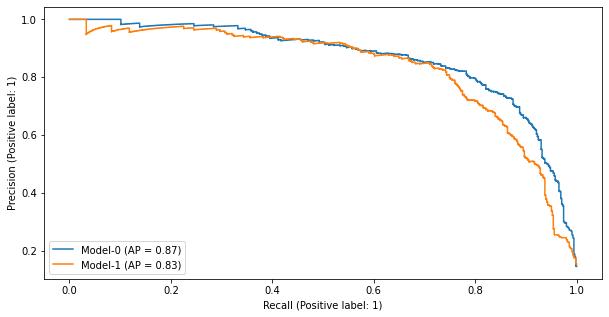

In [58]:
show_pr(result=result, y=train["label_num"])

結果を見ると、ストップワードは精度の向上につながっていないようですので、今回は利用しないことにします。

### ハイパーパラメータを調整

今回のデータは正例がすくないインバランスなデータセットです。
SVCでは `class_weight=balanced` パラメータを指定することで不均衡データの問題を緩和できる可能性があるので、
このパラメータが効くかをチェックしてみましょう。

In [60]:
pipe = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", SVC(random_state=0))
])

params = [
    {
        "clf__class_weight": [None, "balanced"],
    },
]

result = run_cv(pipe=pipe, params=params, cv=cv, X=train["text"], y=train["label_num"], stratify=train["label"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f228bc9de50>)),
                ('clf', SVC(random_state=0))])
Fold: 0
Fold: 1
Fold: 2
Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f228bc9de50>)),
                ('clf', SVC(class_weight='balanced', random_state=0))])
Fold: 0
Fold: 1
Fold: 2


0 {'clf__class_weight': None}
1 {'clf__class_weight': 'balanced'}


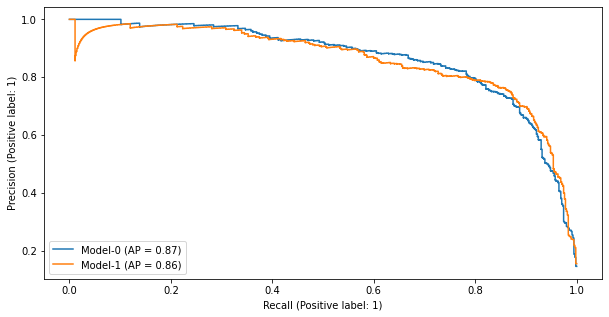

In [61]:
show_pr(result=result, y=train["label_num"])

class_weightを使っても精度の向上は確認できないため、こちらも今回は利用しない方針にします。

## テストセットでの評価

テストセットを使って、選択したモデルの最終的なオフライン評価の結果を出します。

クロスバリデーション時は学習データからバリデーション用のデータを切り出していました。
テストセットでの評価時は、クロスバリデーションで決定したパラメータを用いて、
**全ての学習データ** を使ってモデルを学習します。

In [62]:
pipe = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", SVC(random_state=0)),
])

pipe.fit(X=train["text"], y=train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f228bc9de50>)),
                ('clf', SVC(random_state=0))])

In [63]:
test_pred = pipe.decision_function(X=test["text"])

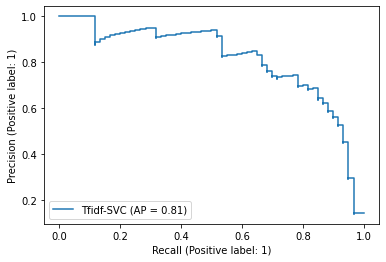

In [65]:
PrecisionRecallDisplay.from_predictions(y_true=test["label_num"], y_pred=test_pred, name=f"Tfidf-SVC")

結果から読み取れることは、
このモデルを使ってスコア付けして信頼度が大きい順に見ていくと、
ネガティブなレビューデータのうち80%をチェックする(recall=0.8)までには、
おおよそ10回に7回(precision=0.7)は実際にネガティブなレビューである、
と言えます。

もしもスコア付けしない場合だと、ネガティブなレビューの割合は

In [68]:
len(train.query('label_num == 1')) / len(train)

0.1438810724714627

なので、10回に1~2回程度しかネガティブなレビューが見つからない結果になるため、
ネガティブなデータを発見するのに効率的になっていると結論付けられます。

問題なければ実際の環境にデプロイを行いA/Bテストを実施してオンライン評価を行います。

## 改善策の検討

問題なくデプロイができたとしても、次のステップとして精度向上を目指すことになります。

ここでは、現在のモデルにどのような問題があるのかをチェックしてみましょう。
問題の把握には、実際にモデルの推論結果をチェックすることが重要です。
推論結果からどのようなケースでミスが多いかを知ることができます。

推論結果をチェックするときに重要なのは、テストセットでの推論結果は**見ない**ことです。
テストセットでの結果を見てしまうと、テストセットに対してチューニングすることになってしまうため、
テストセットでの評価は信頼できないものになってしまいます。

そこで、CVの結果で誤った推論を行なっている結果を、間違えて信頼スコアを大きく出しているものからチェックしてみましょう。

In [70]:
pipe = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize)),
    ("clf", SVC(random_state=0))
])

params = dict()

result = run_cv(pipe=pipe, params=params, cv=cv, X=train["text"], y=train["label_num"], stratify=train["label"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7f228bc9de50>)),
                ('clf', SVC(random_state=0))])
Fold: 0
Fold: 1
Fold: 2


In [71]:
train["cv_baseline"] = result[0][1]

信頼度が大きい方から順にソートした上で、ターゲットのラベルが期待していない `0` であるものをチェックします。

In [73]:
train.sort_values("cv_baseline", ascending=False).query('label_num == 0').head(n=10)

,label,text,judges,label_num,cv_baseline
1107,neutral,悪くはありません。,"{""0"": 3}",0,0.873437
2811,positive,臭いもない。,"{""1"": 3}",0,0.732087
285,neutral,がゴロゴロ。,"{""0"": 3}",0,0.455168
3579,neutral,タバコの臭いが気にならない方で熱い風呂が好きなら良いのでは。,"{""0"": 3}",0,0.368951
3838,positive,前日の宿の部屋がちょっと狭かったので、部屋に入るなり広っ!,"{""1"": 3}",0,0.242181
3876,neutral,1階のレストランは夜の営業をやめてしまったようでモーニングのパニーニも以前ほど種類がない(5...,"{""0"": 3}",0,0.240477
1669,positive,ちょっと嬉しかったです。,"{""1"": 3}",0,0.218728
3334,positive,またベッドの上に折り鶴が置いてあったのですが、何となくホッコリしました。,"{""1"": 3}",0,0.182037
1254,neutral,部屋は狭いですが寝るだけなら十分です。,"{""0"": 3}",0,0.173821
3236,neutral,温泉がないですが、お風呂があります。,"{""0"": 3}",0,0.168143


この結果から、次のようなレビューに対して正しく分類できていないことがわかります。

* 否定系を含むレビュー（例：悪くはない）
* 問題点はあるが、それは解消できることが後からわかるレビュー（例：温泉はないがお風呂はある）

これらのケースに共通することは、文脈を捉える必要があるという点です。
ですので、文脈を捉えるモデルであれば精度が改善するという仮説が立てられます。

では、文脈を捉えるモデルとは何でしょうか。例えば以下の手法を検討することになるでしょう。

* 特徴量としてN-gramを用いる。ただし、特徴量の次元が大きくなる点には注意が必要。
* 文脈を考慮する文ベクトルを使ったニューラルネットワークを用いた手法。ただし、計算コストやモデルサイズに注意が必要。

このようにベースラインを基準に、その結果を分析して次の方針を定めてモデルを改善していきます。